# Advanced Sentiment Analysis using Attention-Augmented BiLSTM Architecture

## Contributors -
### 1. Rohan Inamdar 
### 2. Kavin Sundarr

## DATASET - https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

***Importing Dependency***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import  keras
from sklearn.model_selection import train_test_split


nltk.download('stopwords')

from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix , classification_report ,accuracy_score,ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Visualization

In [2]:
df_valid = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names=['userID', 'boarderland', 'sentiments', 'text'])
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',names=['userID', 'boarderland', 'sentiments', 'text'])

In [3]:
df.info()
print('-'*100)
print(df_valid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       74682 non-null  int64 
 1   boarderland  74682 non-null  object
 2   sentiments   74682 non-null  object
 3   text         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userID       1000 non-null   int64 
 1   boarderland  1000 non-null   object
 2   sentiments   1000 non-null   object
 3   text         1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None


In [4]:
print(f'The shape of the training dataset is : {df.shape}')
print('--------')
print(f'The shape of the validation dataset is : {df_valid.shape}')

The shape of the training dataset is : (74682, 4)
--------
The shape of the validation dataset is : (1000, 4)


# Data Cleaning and Processing

In [5]:
df.isnull().sum()

userID           0
boarderland      0
sentiments       0
text           686
dtype: int64

In [6]:
df = df.dropna()

In [7]:
print(f"Ducpicated sum of training Dataset: {df['text'].duplicated().sum()}")
print(f"Ducpicated sum of validation Dataset: {df_valid['text'].duplicated().sum()}")

Ducpicated sum of training Dataset: 4505
Ducpicated sum of validation Dataset: 1


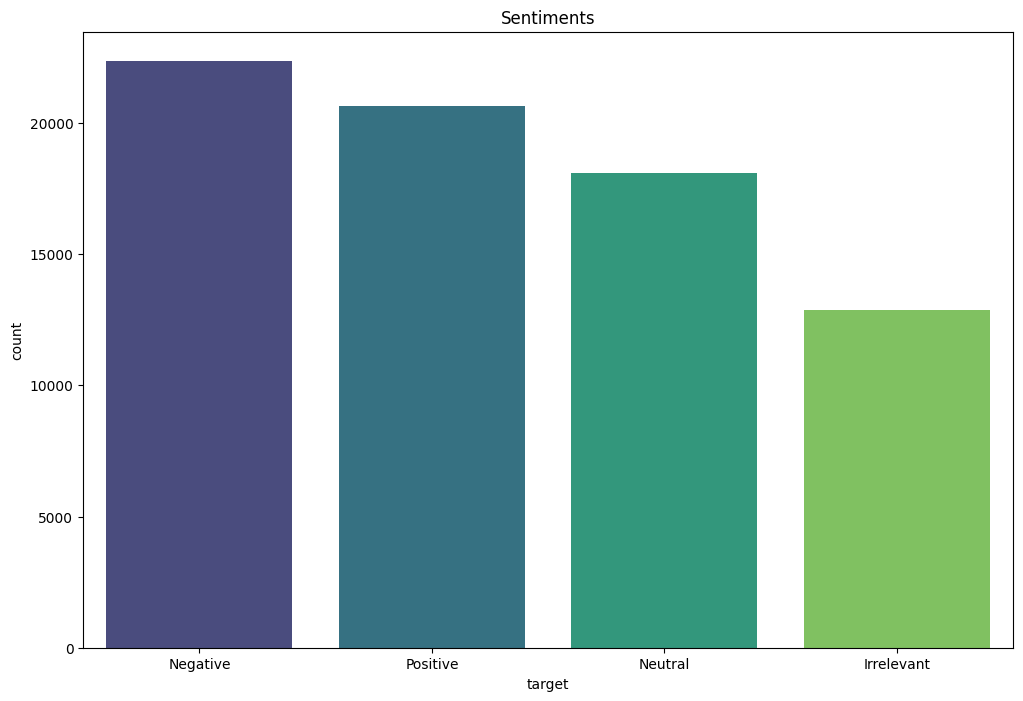

In [8]:
count=df['sentiments'].value_counts()
count
plt.figure(figsize=(12,8))
sns.barplot(x=count.index,y=count.values,palette='viridis')
plt.title('Sentiments')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

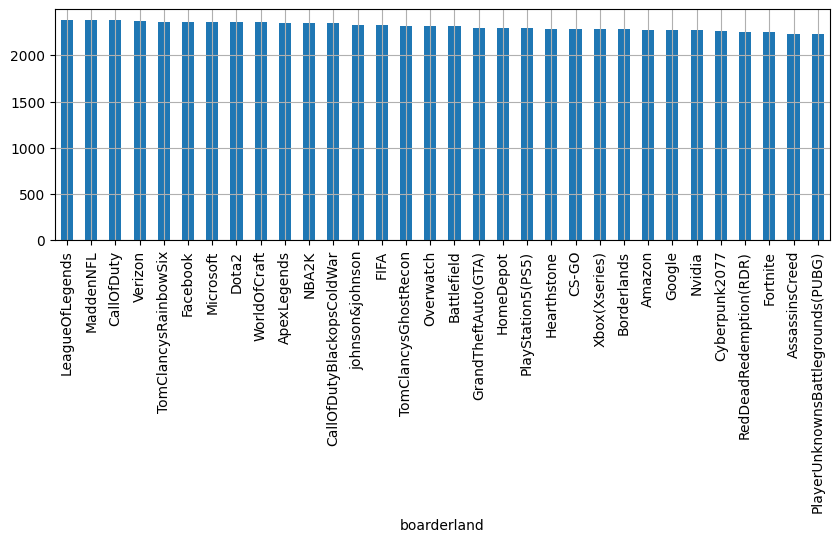

In [9]:
plt.figure(figsize=(10,3))
df['boarderland'].value_counts().plot(kind='bar', grid=True)
plt.show()

In [10]:
df = df.drop_duplicates(subset=['text'], keep='first')
df_valid = df_valid.drop_duplicates(subset=['text'], keep='first')
print(f'The shape of the training dataset is : {df.shape}')
print(f'The shape of the valid dataset is : {df_valid.shape}')

The shape of the training dataset is : (69491, 4)
The shape of the valid dataset is : (999, 4)


# Preprocessing

In [11]:
#clean text by removing everything except alphabets

stmr = PorterStemmer()

def preprocess_text(txt):
  lst = []
  stop_words = set(stopwords.words('english'))

  for i in txt:
    cln = re.sub('[^a-zA-Z]',' ',i)
    cln = cln.lower()
    cln = cln.split()
    cln = [f for f in cln if f not in stop_words]
    cln = [stmr.stem(l) for l in cln]
    cln = ' '.join(cln)
    lst.append(cln)
  return lst



text = preprocess_text(df['text'])
valid_text = preprocess_text(df_valid['text'])

In [12]:
df1 = pd.DataFrame({'text': text, 'sentiments': df['sentiments']})
df1_valid = pd.DataFrame({'text': valid_text, 'sentiments': df_valid['sentiments']})

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

tkr=Tokenizer(num_words=10000) #To cap the maximum vocab size as  10,000

#To fit Tokenizer on Text
tkr.fit_on_texts(df1['text'])
tkr.fit_on_texts(df1_valid['text'])

#To convert text into sequences(VECTORS)
X = tkr.texts_to_sequences(df1['text'])
X_valid = tkr.texts_to_sequences(df1_valid['text'])

In [14]:
print(f"Previous Data      :  {df1['text'][0]}")
print(f"Preprocessed Data  : {X[0]}")

Previous Data      :  im get borderland murder
Preprocessed Data  : [213, 4, 74, 1204]


In [15]:
max_len=100 #Defining the maximum sequence length

X = pad_sequences(X, maxlen=max_len, padding='post')
X_val = pad_sequences(X_valid, maxlen=max_len, padding='post')
y = df1['sentiments']
y_valid = df1_valid['sentiments']

lbl = LabelEncoder()

y = lbl.fit_transform(y)
y_val = lbl.transform(y_valid)

y = to_categorical(y)
y_val = to_categorical(y_val, num_classes=4)

In [16]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [17]:
def shape():
  for i in [X,y, X_val, y_val, X_test,y_test]:
    print(f'{i.shape}')
    
shape()

(55592, 100)
(55592, 4)
(999, 100)
(999, 4)
(13899, 100)
(13899, 4)


# Model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [19]:
# Model architecture with Functional API and MultiHeadAttention
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
lstm_layer = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(embedding_layer)

# MultiHeadAttention requires multiple inputs: query, key, and value
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(lstm_layer, lstm_layer)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)  # Normalize after attention

pooled_output = GlobalAveragePooling1D()(attention_output)
dropout_layer = Dropout(0.5)(pooled_output)
batch_norm_layer = BatchNormalization()(dropout_layer)
dense_layer = Dense(64, activation='relu')(batch_norm_layer)
dropout_layer_2 = Dropout(0.5)(dense_layer)
output_layer = Dense(4, activation='softmax')(dropout_layer_2)  # Assuming 4 sentiment classes

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 128)  │        256 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,651,908 (6.30 MB)

 Trainable params: 1,651,652 (6.30 MB)

 Non-trainable params: 256 (1.00 KB)

# Training

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW  # Use AdamW optimizer
import os

# Creating the output directory (Kaggle output directory)
output_dir = '/kaggle/working/output/'  # Adjust path as needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the learning rate scheduler with more adaptive settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# Early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(filepath=os.path.join(output_dir, 'best_model_accuracy.keras'),
                                   monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

# Adaptive learning rate with AdamW optimizer
initial_learning_rate = 0.0005  # Start with a smaller learning rate
adamw = AdamW(learning_rate=initial_learning_rate, weight_decay=1e-4)

# Compile the model with categorical crossentropy and accuracy
model.compile(optimizer=adamw, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    X, y,
    epochs=50,
    batch_size=128,  # Using a smaller batch size
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    verbose=1
)

# Save the final model after training completes
model.save(os.path.join(output_dir, 'final_model.keras'))

print(f"Models saved in: {output_dir}")


Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2651 - loss: 1.7599
Epoch 1: val_accuracy improved from -inf to 0.60630, saving model to /kaggle/working/output/best_model_accuracy.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 105s 223ms/step - accuracy: 0.2653 - loss: 1.7594 - val_accuracy: 0.6063 - val_loss: 0.9791 - learning_rate: 5.0000e-04
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6652 - loss: 0.8880
Epoch 2: val_accuracy improved from 0.60630 to 0.76559, saving model to /kaggle/working/output/best_model_accuracy.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 96s 221ms/step - accuracy: 0.6653 - loss: 0.8878 - val_accuracy: 0.7656 - val_loss: 0.6279 - learning_rate: 5.0000e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8000 - loss: 0.5790
Epoch 3: val_accuracy improved from 0.76559 to 0.80819, saving model to /kaggle/working/output/best_model_accuracy.keras
435/435 ━━━━━━━━━━━━━━━━━━━━ 97s 223ms/step - accuracy: 0.8000 - loss: 0.5790 -

# Results and Discussion

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import os

# Load the best model (based on highest validation accuracy)
model.load_weights(os.path.join(output_dir, 'final_model.keras'))

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix with labels
labels = ['irrelevant', 'negative', 'neutral', 'positive']
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(pd.DataFrame(conf_matrix, index=labels, columns=labels))

# Classification report for class-wise metrics
class_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Convert classification report into a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Print class-wise accuracy, F1 score, recall, and precision
print('\nClass-wise and Overall Metrics:')
print(class_report_df[['precision', 'recall', 'f1-score', 'support']])

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'\nOverall Accuracy: {accuracy:.4f}')


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step
Confusion Matrix:
            irrelevant  negative  neutral  positive
irrelevant        2039       151       68       216
negative           103      3789      154       214
neutral            120       192     2799       286
positive           155       250      134      3229

Class-wise and Overall Metrics:
              precision    recall  f1-score       support
irrelevant     0.843608  0.824171  0.833776   2474.000000
negative       0.864674  0.889437  0.876880   4260.000000
neutral        0.887163  0.823962  0.854396   3397.000000
positive       0.818504  0.856953  0.837288   3768.000000
accuracy       0.853011  0.853011  0.853011      0.853011
macro avg      0.853487  0.848631  0.850585  13899.000000
weighted avg   0.853904  0.853011  0.852979  13899.000000

Overall Accuracy: 0.8530


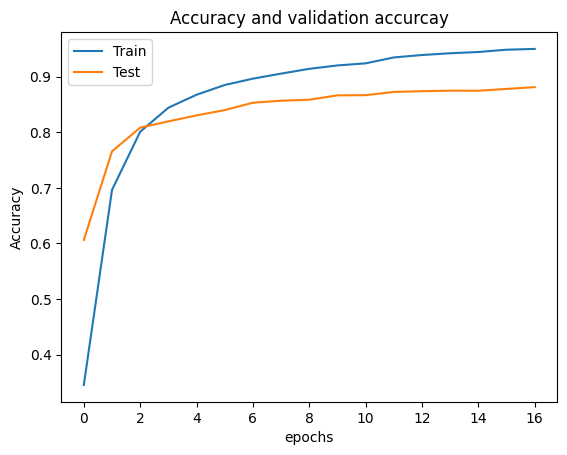

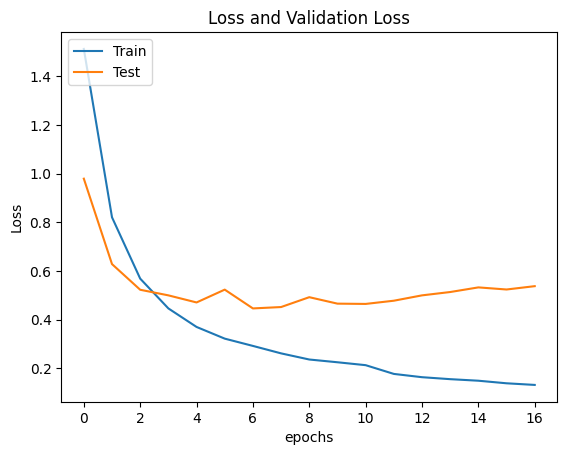

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and validation accurcay')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc= 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc= 'upper left')
plt.show()

# Predictions

In [23]:
# Load the saved weights
model.load_weights(os.path.join(output_dir, 'final_model.keras'))

import numpy as np

# Define the class labels
class_labels = ['irrelevant', 'negative', 'neutral', 'positive']

# Make predictions using the loaded model
for i in range(12):
    input_sequence = X_val[i].reshape(1, -1)  # Reshape the input for prediction
    real_class_index = np.argmax(y_val[i])  # Get the real class index from y_val
    predicted_class_index = np.argmax(model.predict(input_sequence, verbose=0))  # Predict the class index

    # Display the actual text, real label, and predicted label
    print("---------------------------------")
    print(f'Actual value from the Validation Dataset: {class_labels[real_class_index]}')
    print(f'Predicted value by Our Model: {class_labels[predicted_class_index]}')


---------------------------------
Actual value from the Validation Dataset: irrelevant
Predicted value by Our Model: irrelevant
---------------------------------
Actual value from the Validation Dataset: neutral
Predicted value by Our Model: neutral
---------------------------------
Actual value from the Validation Dataset: negative
Predicted value by Our Model: negative
---------------------------------
Actual value from the Validation Dataset: negative
Predicted value by Our Model: negative
---------------------------------
Actual value from the Validation Dataset: neutral
Predicted value by Our Model: neutral
---------------------------------
Actual value from the Validation Dataset: negative
Predicted value by Our Model: negative
---------------------------------
Actual value from the Validation Dataset: positive
Predicted value by Our Model: positive
---------------------------------
Actual value from the Validation Dataset: positive
Predicted value by Our Model: positive
--------